In [1]:
import os
from time import time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import jax.numpy as jnp
import multihist as mh
from numba import njit
import json

import appletree as apt
from appletree.utils import get_file_path

XLA_PYTHON_CLIENT_PREALLOCATE is set to false
XLA_PYTHON_CLIENT_ALLOCATOR is set to platform
Using aptext package from https://github.com/XENONnT/applefiles


In [3]:
# constrain the GPU memory usage

apt.set_gpu_memory_usage(0.2)

## Define component

### Running-r method

In [4]:
from jax import jit, vmap

In [5]:
from numba import njit
from tqdm import tqdm
import scipy.optimize as optimize

In [6]:
@njit
def running(N_ini, P): # p = ct*n, n is expected number of ions !!!
    ni = N_ini 
    Ct = P / N_ini
    for i in range(N_ini):
        ra = (1 - np.log(1 + Ct*ni) / (Ct*ni)) # instant recomb. prob.
        ni -= ra 
    return 1 - ni / N_ini # The final number of remained electrons

@njit
def running_mc(n, p):
    a = n
    c = p / n
    for i in range(n):
        ra = (1 - np.log(1 + c * a) / (c  * a))
        if np.random.rand() < ra:
            a -= 1
    return 1 - a / n

def mini_running(P, r, N_ini):
    P = 10**(float(P))  # or P = P[0] if input is a 1D array. P=Ct*N_ini 
    return np.abs((running(N_ini, P) - r)) # difference b/w the simulated r and true r

def mini_running_mc(x, r, n):
    x = 10**(float(x))
    return np.abs(running_mc(n, x) - r)

In [192]:
r_values_x = np.linspace(0.005, 0.995, 1000)
x_opt_values_x = []
N_ini = 200
for r in tqdm(r_values_x):
    result = optimize.minimize(mini_running, [2], args=(r, N_ini), method='powell')
    x_opt_values_x.append(result.x[0])  # Extract scalar x
x_opt_values_x = np.array(x_opt_values_x)

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_2005781/248957427.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P = 10**(float(P))  # or P = P[0] if input is a 1D array. P=Ct*N_ini
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.00it/s]


In [196]:
x_opt_values_x_1000 = []
N_ini = 1000
for r in tqdm(r_values_x):
    result = optimize.minimize(mini_running, [2], args=(r, N_ini), method='powell')
    x_opt_values_x_1000.append(result.x[0])  # Extract scalar x
x_opt_values_x_1000 = np.array(x_opt_values_x_1000)

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_2005781/248957427.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P = 10**(float(P))  # or P = P[0] if input is a 1D array. P=Ct*N_ini
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.80it/s]


In [212]:
def func(x,a,b,c,d,e):
    return a - b*np.log(x**(c+d*(x**e))-1)
cf_par, cf_cov = optimize.curve_fit(f=func, xdata=r_values_x, ydata=x_opt_values_x, 
                                    p0=[0.23173533, 0.58577789, -0.72041178, 0.29412095, 2.55659529])

In [213]:
cf_par

array([ 0.23802112,  0.58247898, -0.72696011,  0.3068595 ,  2.55739627])

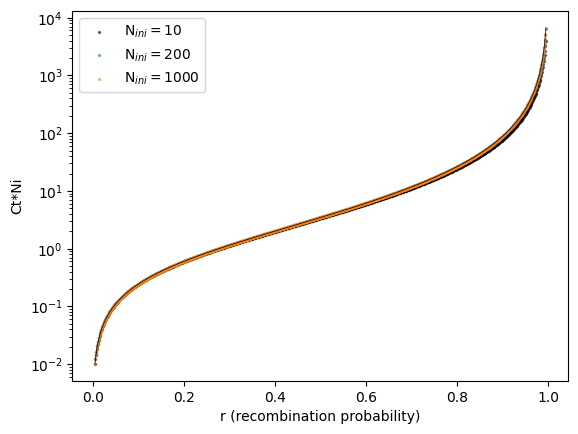

In [214]:
plt.plot(r_values_x, 10**func(r_values_x, *cf_par), c='k', lw=0.5)
#plt.plot(r_values_x, 10**func(r_values_x, 0.23173533, 0.58577789, -0.72041178, 0.29412095, 2.55659529), c='r', lw=0.5)
plt.scatter(r_values_x, 10**x_opt_values_x_10, s=2, label='N$_{ini}=10$', alpha=0.5, c='k')
plt.scatter(r_values_x, 10**x_opt_values_x, s=2, label='N$_{ini}=200$', alpha=0.5)
plt.scatter(r_values_x, 10**x_opt_values_x_1000, s=2, label='N$_{ini}=1000$', alpha=0.5)
plt.xlabel('r (recombination probability)')
plt.ylabel('Ct*Ni')
plt.yscale('log')
plt.legend();

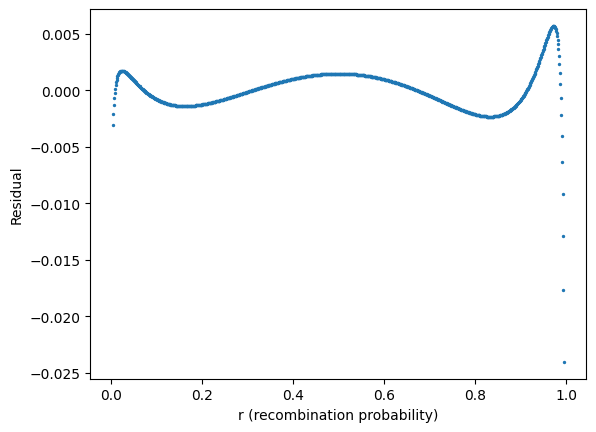

In [216]:
plt.scatter(r_values_x, x_opt_values_x - func(r_values_x, *cf_par), s=2)
plt.xlabel('r (recombination probability)')
plt.ylabel('Residual');

In [4]:
# The components is associated with bins, so first we load bins
data = pd.read_csv("/stor0/kaminaga/data/Xe131m_afterAmBe_sr1_wimp_unblind_20p.csv")
#pd.read_csv("~/appletree/applefiles/files/ar37/data_ar37_sr0.csv")
bins_cs1, bins_cs2 = apt.utils.get_equiprob_bins_2d(
    data[["cs1", "cs2"]].to_numpy(),
    [15, 15],
    order=[0, 1],
    x_clip=[1000, 1700], #[0, 40],
    y_clip=[10000, 60000], #[1247, 2213],
    which_np=jnp,
)

/opt/conda/envs/el7.2025.03.1/lib/python3.11/site-packages/GOFevaluation/utils.py:249: UserWarning: reference_sample contains ties, this might cause problems in the equiprobable binning.
  check_for_ties(reference_sample, dim=dim)


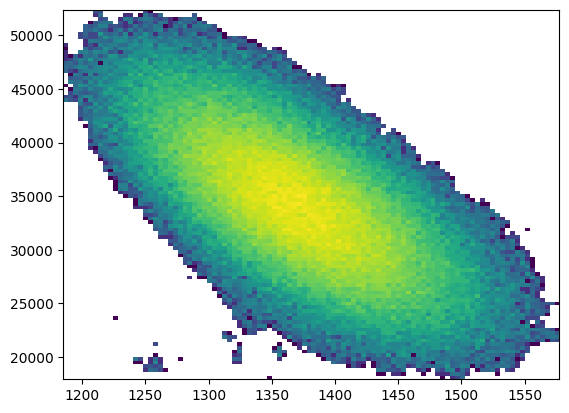

In [10]:
plt.hist2d(data['cs1'], data['cs2'], norm=LogNorm(), bins=100);

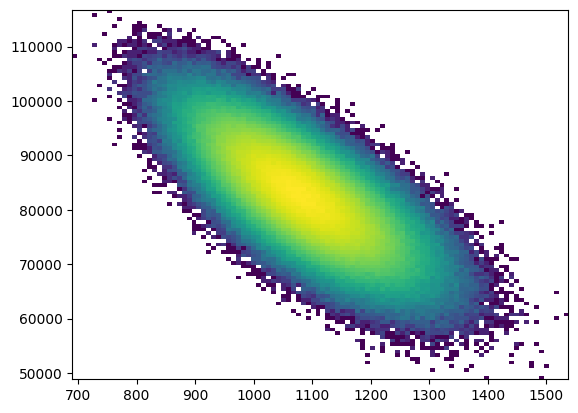

In [17]:
plt.hist2d(cs1, cs2, bins=100, norm=LogNorm());

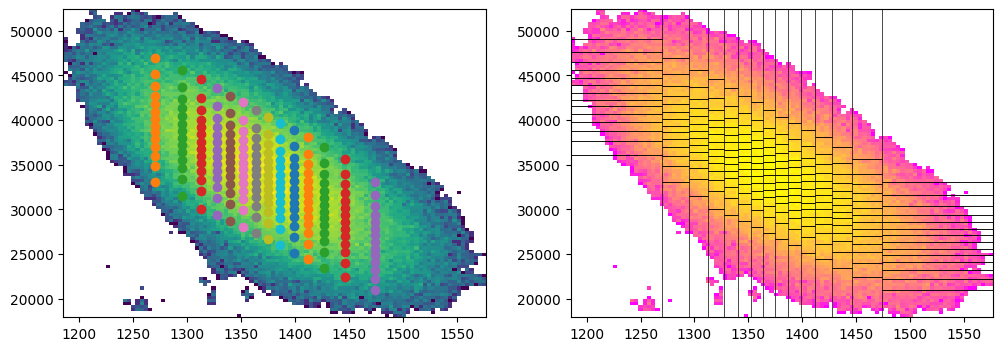

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist2d(data['cs1'], data['cs2'], bins=100, norm=LogNorm())
for i in range(len(bins_cs1)):
    ax[0].scatter([float(bins_cs1[i])]*len(bins_cs2[i]), bins_cs2[i])
ax[1].hist2d(data['cs1'], data['cs2'], bins=100, norm=LogNorm(), cmap='spring')
ax[1].vlines(bins_cs1, data['cs2'].min(), data['cs2'].max(), color='k', lw=0.5)
for i in range(len(bins_cs1)-1):
    ax[1].hlines([bins_cs2[i],bins_cs2[i]], bins_cs1[i], bins_cs1[i+1], color='k', lw=0.5);

In [8]:
# Initialize component
Xe = apt.ERPeak(bins=[bins_cs1, bins_cs2], bins_type="irreg")

In [6]:
# Deduce the workflow(datastructure)
Ar_run.deduce(data_names=["cs1", "cs2"], func_name="simulate")  # 'eff'(efficiency) is always simulated
Ar_run.rate_name = "Ar_rate"  # also we have to specify a normalization factor of the component

# Compile ER script
# This is meta-programing because  appletree can generate codes dynamically
Ar_run.compile()

RunningR_llh's map s2_cut_acc is using the parameter s2_cut_acc_sigma.
RunningR_llh's map s1_cut_acc is using the parameter s1_cut_acc_sigma.
RunningR_llh's map s1_eff_3f is static and not using any parameter.


In [22]:
# For reference, this is the compiled code, the function is stored in appletree.share._cached_functions
print(Xe.code)

from functools import partial
from jax import jit
from appletree.plugins import PositionSpectra
from appletree.plugins import MonoEnergySpectra
from appletree.plugins import RecombFluct
from appletree.plugins import mTI
from appletree.plugins import Quanta
from appletree.plugins import TrueRecombER
from appletree.plugins import IonizationER
from appletree.plugins import DriftLoss
from appletree.plugins import RecombinationER
from appletree.plugins import S2LCE
from appletree.plugins import ElectronDrifted
from appletree.plugins import S2PE
from appletree.plugins import S2
from appletree.plugins import S1LCE
from appletree.plugins import PhotonDetection
from appletree.plugins import S1PE
from appletree.plugins import S1
from appletree.plugins import S2CutAccept
from appletree.plugins import S1CutAccept
from appletree.plugins import S1ReconEff
from appletree.plugins import S2Threshold
from appletree.plugins import PositionRecon
from appletree.plugins import S2Correction
from appletree.pl

## Load parameters

In [7]:
get_file_path("list_er_constantr_xe131m.json")

'/home/ykaminaga/.local/lib/python3.11/site-packages/appletree/parameters/list_er_constantr_xe131m.json'

In [39]:
# Of course we have to load parameters(and their priors) in simulation

#par_manager = apt.Parameter(get_file_path("er_constantr_xe131m.json"))
#par_manager.sample_init()
#parameters = par_manager.get_all_parameter()
with open(get_file_path("list_er_constantr_xe131m.json")) as f:
    er_parameters = json.load(f)

In [6]:
parameters['s1_cut_acc_sigma'] = parameters.pop('s1_cut_acc_sigma_ar37')
parameters['s2_cut_acc_sigma'] = parameters.pop('s2_cut_acc_sigma_ar37')

In [17]:
parameters

{'w': np.float64(0.016708286735451317),
 'fano': 0.059,
 'gas_gain': 31.3,
 'drift_velocity': 0.0677,
 's2_threshold': 500.0,
 'field': 23.0,
 'nex_ni_ratio': np.float64(0.06),
 'g1': np.float64(0.16233969649054644),
 'g2': np.float64(30.995442982983985),
 'p_dpe': np.float64(0.0),
 'elife_sigma': np.float64(-0.6787607387287182),
 's1_eff_3f_sigma': np.float64(3.739851091912923),
 's1_cut_acc_sigma': np.float64(4.378543022561286),
 's2_cut_acc_sigma': np.float64(5.0),
 'py0': np.float64(0.32085443055672425),
 'py1': np.float64(47.017467491182394),
 'py2': np.float64(0.03734567295282758),
 'py3': np.float64(4.830313797226803),
 'py4': np.float64(-0.5792670173924435),
 'rf0': np.float64(0.0344975424065999),
 'rf1': np.float64(3.8546970146046124),
 'xe131m_ac_rate': np.float64(114.95656282826181),
 'xe131m_er_rate': np.float64(4993.951749613913)}

In [22]:
#par_manager.par_config
er_parameters

{'w': 0.017122864924642784,
 'fano': 0.059,
 'gas_gain': 31.3,
 'drift_velocity': 0.0677,
 's2_threshold': 500.0,
 'field': 23.0,
 'nex_ni_ratio': 0.060054194540849065,
 'g1': 0.16187397038673612,
 'g2': 31.20431119583207,
 'p_dpe': 0.004164598168373954,
 'elife_sigma': -0.6598878177922057,
 's1_eff_3f_sigma': 3.666913384715933,
 's1_cut_acc_sigma': 3.8094982974939553,
 's2_cut_acc_sigma': 4.9411554663232655,
 'py0': 0.336137735669424,
 'py1': 46.65294155808996,
 'py2': 0.06714746826249048,
 'py3': 4.873217791071433,
 'py4': 0.03970598338052786,
 'rf0': 0.027070298849512064,
 'rf1': 3.9394020746803666,
 'xe131m_er_rate': 4867.786588393052,
 'xe131m_ac_rate': 116.16519292174317}

## Simulation

In [6]:
# Really do the simulation

batch_size = int(1e6)
key = apt.randgen.get_key(seed=137)

#key, (cs1, cs2, eff) = Ar_run.simulate(key, batch_size, parameters)

In [40]:
#Xe = apt.ERPeak(bins=[bins_cs1, bins_cs2], bins_type="irreg")
#Xe.deduce(data_names=["cs1", "cs2"], func_name="simulate")
Xe.rate_name = "xe131m_er_rate"
Xe.compile()
key, (cs1, cs2, eff) = Xe.simulate(key, batch_size, er_parameters)

ERPeak_llh's map s2_cut_acc is using the parameter s2_cut_acc_sigma.
ERPeak_llh's map s1_cut_acc is using the parameter s1_cut_acc_sigma.
ERPeak_llh's map s1_eff_3f is static and not using any parameter.


In [41]:
#Xe_con = apt.ConstantR(bins=[bins_cs1, bins_cs2], bins_type="irreg")
#Xe_con.deduce(data_names=["cs1", "cs2"], func_name="simulate")
Xe_con.rate_name = "xe131m_er_rate"
Xe_con.compile()
key, (cs1_con, cs2_con, eff) = Xe_con.simulate(key, batch_size, er_parameters)

ConstantR_llh's map s2_cut_acc is using the parameter s2_cut_acc_sigma.
ConstantR_llh's map s1_cut_acc is using the parameter s1_cut_acc_sigma.
ConstantR_llh's map s1_eff_3f is static and not using any parameter.


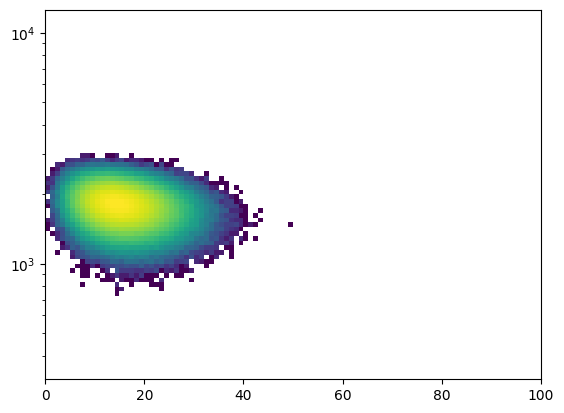

In [13]:
plt.hist2d(cs1, cs2, bins=(jnp.linspace(0, 100, 101), jnp.logspace(2.5, 4.1, 81)), norm=LogNorm())
plt.yscale("log");

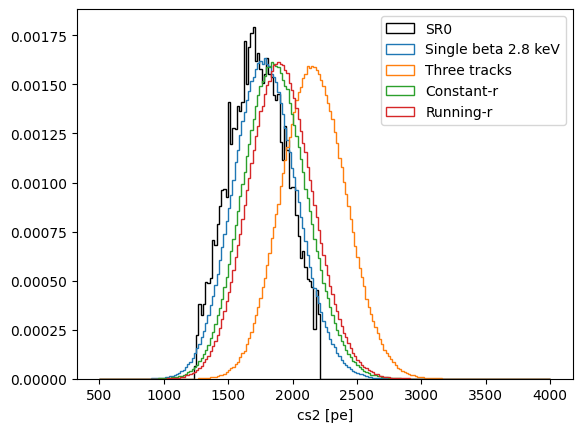

In [19]:
plt.hist(data.cs2, range=(500,4000), bins=200, histtype='step', density=True, color='k', label='SR0')
plt.hist(cs2, range=(500,4000), bins=200, histtype='step', density=True, label='Single beta 2.8 keV')
plt.hist(cs2_ori, range=(500,4000), bins=200, histtype='step', density=True, label='Three tracks')
plt.hist(cs2_con, range=(500,4000), bins=200, histtype='step', density=True, label='Constant-r')
plt.hist(cs2_run, range=(500,4000), bins=200, histtype='step', density=True, label='Running-r')
plt.legend()
plt.xlabel('cs2 [pe]');

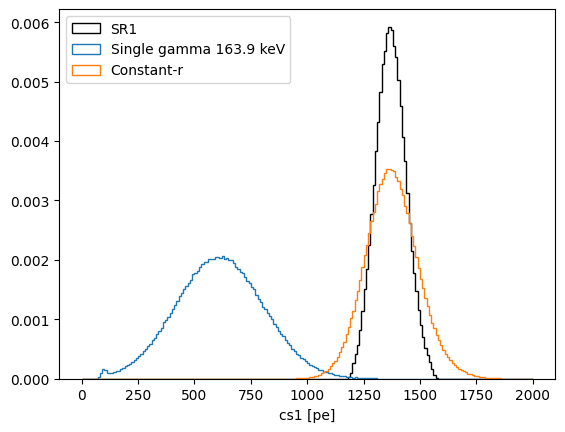

In [42]:
plt.hist(data.cs1, range=(0,2000), bins=200, histtype='step', density=True, label='SR1', color='k')
plt.hist(cs1, range=(0,2000), bins=200, histtype='step', density=True, label='Single gamma 163.9 keV')
plt.hist(cs1_con, range=(0,2000), bins=200, histtype='step', density=True, label='Constant-r')
plt.legend()
plt.xlabel('cs1 [pe]');

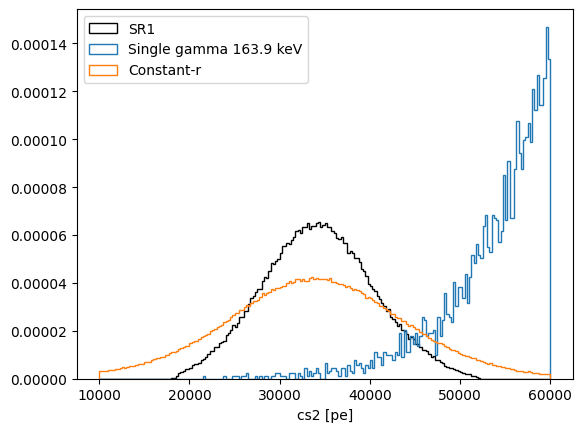

In [43]:
plt.hist(data.cs2, range=(10000,60000), bins=200, histtype='step', density=True, label='SR1', color='k')
plt.hist(cs2, range=(10000,60000), bins=200, histtype='step', density=True, label='Single gamma 163.9 keV')
plt.hist(cs2_con, range=(10000,60000), bins=200, histtype='step', density=True, label='Constant-r')
plt.legend()
plt.xlabel('cs2 [pe]');

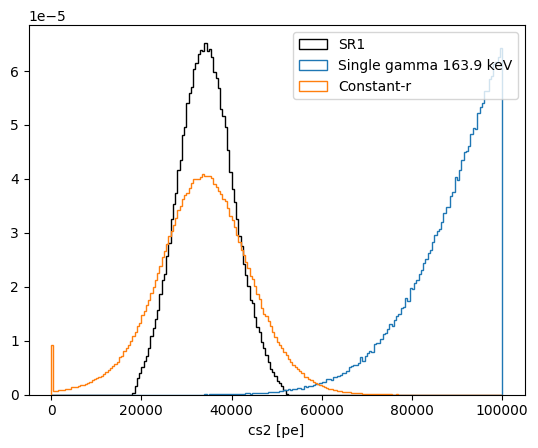

In [44]:
plt.hist(data.cs2, range=(0,100000), bins=200, histtype='step', density=True, label='SR1', color='k')
plt.hist(cs2, range=(0,100000), bins=200, histtype='step', density=True, label='Single gamma 163.9 keV')
#plt.hist(cs2_ori, range=(0,100000), bins=200, histtype='step', density=True, label='Three tracks')
plt.hist(cs2_con, range=(0,100000), bins=200, histtype='step', density=True, label='Constant-r')
#plt.hist(cs2_run, range=(0,100000), bins=200, histtype='step', density=True, label='Running-r')
plt.legend()
plt.xlabel('cs2 [pe]');

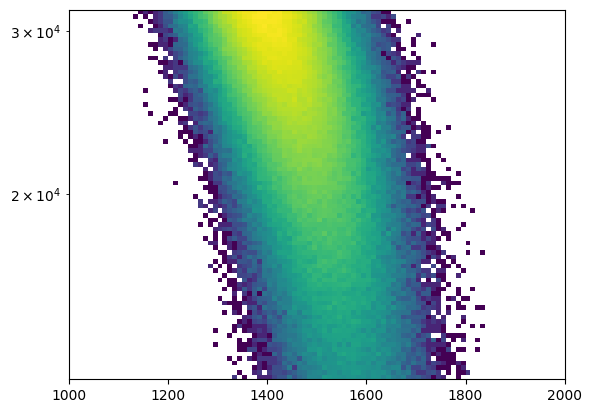

In [45]:
plt.hist2d(cs1_con, cs2_con, bins=(jnp.linspace(1000, 2000, 101), jnp.logspace(4.1, 4.5, 81)), norm=LogNorm())
plt.yscale("log");

In [6]:
Ar_mono = apt.RunningR(bins=np.arange(0,200,2), bins_type="irreg")
Ar_mono.deduce(data_names=["num_ion_x", "num_ion_y", "num_ion_z"], func_name="simulate")
Ar_mono.rate_name = "ER_rate"
Ar_mono.compile()
key, (n_x, n_y, n_z, eff) = Ar_mono.simulate(key, batch_size, parameters)

RunningR_llh's map s2_cut_acc is using the parameter s2_cut_acc_sigma.
RunningR_llh's map s1_cut_acc is using the parameter s1_cut_acc_sigma.
RunningR_llh's map s1_eff_3f is static and not using any parameter.


In [108]:
print(n_x.mean(), n_y.mean(), n_z.mean())

155.10252 13.311275 17.971756


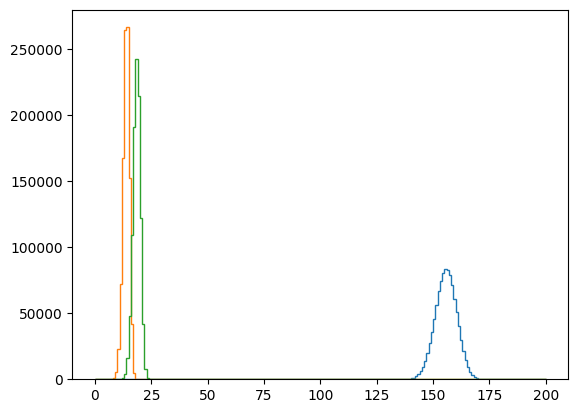

In [107]:
plt.hist(n_x, range=(0,200), bins=200, histtype='step')
plt.hist(n_y, range=(0,200), bins=200, histtype='step')
plt.hist(n_z, range=(0,200), bins=200, histtype='step');

In [13]:
Ar_mono_ori = apt.OriginalR(bins=np.arange(60,160), bins_type="irreg")
Ar_mono_ori.deduce(data_names=["num_photon", "num_electron"], func_name="simulate")
Ar_mono_ori.rate_name = "ER_rate"
Ar_mono_ori.compile()

OriginalR_llh's map s2_cut_acc is using the parameter s2_cut_acc_sigma.
OriginalR_llh's map s1_cut_acc is using the parameter s1_cut_acc_sigma.
OriginalR_llh's map s1_eff_3f is static and not using any parameter.


In [14]:
key, (num_ph_ori, num_el_ori, eff) = Ar_mono_ori.simulate(key, batch_size, parameters)

In [8]:
num_el_run

Array([144, 149, 135, ..., 136, 149, 152], dtype=int32)

In [43]:
# SR0 condition
parameters['g1'] = float(0.151)
parameters['g2'] = float(16.5)

In [33]:
data.cs2.mean()/16.5

np.float64(105.0041967230303)

In [35]:
data.cs2.std()/16.5

np.float64(13.178210274593683)

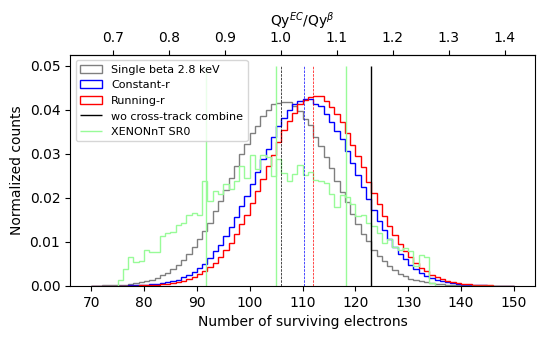

In [48]:
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot(111)

ax1.hist(num_el, bins=80, range=(70,150), histtype='step', label='Single beta 2.8 keV', color='k', alpha=0.5, density=True)
#ax1.hist(num_el_ori, bins=80, range=(70,150), histtype='step', label='Three tracks', density=True)
ax1.hist(num_el_con, bins=80, range=(70,150), histtype='step', label='Constant-r', color='b', density=True)
ax1.hist(num_el_run, bins=80, range=(70,150), histtype='step', label='Running-r', color='r', density=True)
ax1.hist(data.cs2/16.5, bins=80, range=(70,150), histtype='step', color='palegreen', density=True)
ax1.vlines([num_el.mean(), num_el_con.mean(), num_el_run.mean()], 0, 0.05, ls='dashed', lw=0.5, colors=['k', 'b', 'r'])
ax1.vlines([num_el_ori.mean()], 0, 0.05, colors=['k'], lw=1, label='wo cross-track combine')
ax1.vlines(np.array([data.cs2.mean()-data.cs2.std(), data.cs2.mean(), data.cs2.mean()+data.cs2.std()])/16.5, 0, 0.05, 
           colors=['palegreen'], lw=1, label='XENONnT SR0')
ax1.legend(fontsize=8, loc='upper left')
ax1.set_xlabel('Number of surviving electrons')
ax1.set_ylabel('Normalized counts')
ax2 = ax1.secondary_xaxis('top', functions=(lambda x: x/num_el.mean(), lambda x: x/num_el.mean()))
ax2.set_xlabel('Qy$^{EC}$/Qy$^β$');

In [16]:
print(num_el.mean(), num_el_con.mean(), num_el_run.mean(), num_el_ori.mean())

105.895645 110.34387 111.93111 122.89178


In [29]:
(num_el_ori.mean() - num_el_con.mean())/num_el_con.mean()

Array(0.1122732, dtype=float32)

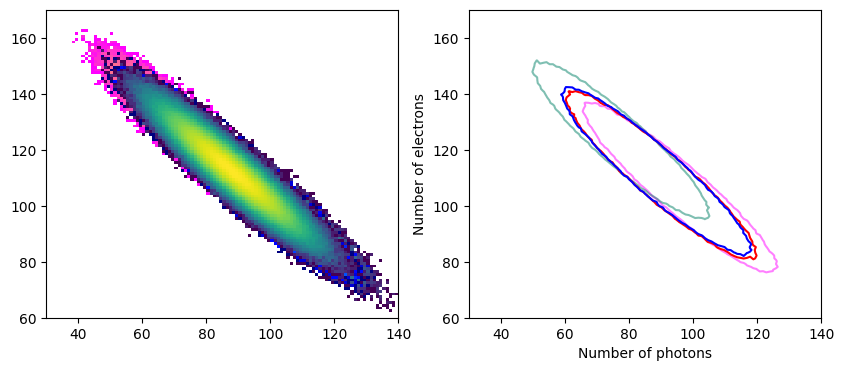

In [49]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
counts, xedges, yedges, Image= ax[0].hist2d(num_ph, num_el, range=((30,140),(60,170)), bins=(110,110), norm=LogNorm(), cmap='viridis')
counts_o, xedges_o, yedges_o, Image_o= ax[0].hist2d(num_ph_ori, num_el_ori, range=((30,140),(60,170)), bins=(110,110), norm=LogNorm(), cmap='spring')
counts_c, xedges_c, yedges_c, Image_c= ax[0].hist2d(num_ph_con, num_el_con, range=((30,140),(60,170)), bins=(110,110), norm=LogNorm(), cmap=cm.jet)
counts_r, xedges_r, yedges_r, Image_r= ax[0].hist2d(num_ph_run, num_el_run, range=((30,140),(60,170)), bins=(110,110), norm=LogNorm(), cmap='viridis')

ax[1].contour(counts.transpose(),extent=[xedges.min(),xedges.max(),yedges.min(),yedges.max()], levels=[32], cmap='spring', alpha=0.5)
ax[1].contour(counts_o.transpose(),extent=[xedges_o.min(),xedges_o.max(),yedges_o.min(),yedges_o.max()], levels=[32], cmap='summer', alpha=0.5)
ax[1].contour(counts_c.transpose(),extent=[xedges_c.min(),xedges_c.max(),yedges_c.min(),yedges_c.max()], levels=[32], cmap='autumn')
ax[1].contour(counts_r.transpose(),extent=[xedges_r.min(),xedges_r.max(),yedges_r.min(),yedges_r.max()], levels=[32], cmap='winter')
ax[1].set_xlabel('Number of photons'); ax[1].set_ylabel('Number of electrons');

## Simulation and make equiprob hist

In [14]:
# Actually `simulate_hist` is just a wrapper of `simulate`

batch_size = int(1e6)
key = apt.randgen.get_key(seed=137)
key, h = Xe.simulate_hist(key, batch_size, parameters)

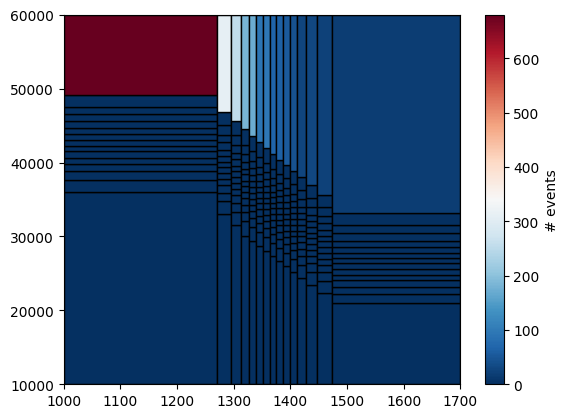

In [16]:
apt.utils.plot_irreg_histogram_2d(bins_cs1, bins_cs2, h, density=False)
plt.show()

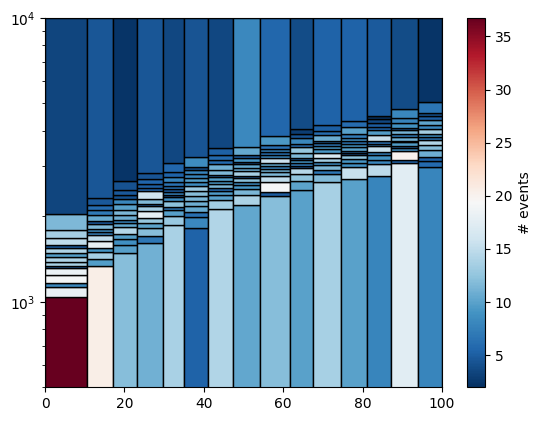

In [20]:
apt.utils.plot_irreg_histogram_2d(bins_cs1, bins_cs2, h, density=False)
plt.yscale("log")
plt.ylim(5e2, 1e4)
plt.show()

In [21]:
h = ac.simulate_hist(parameters)

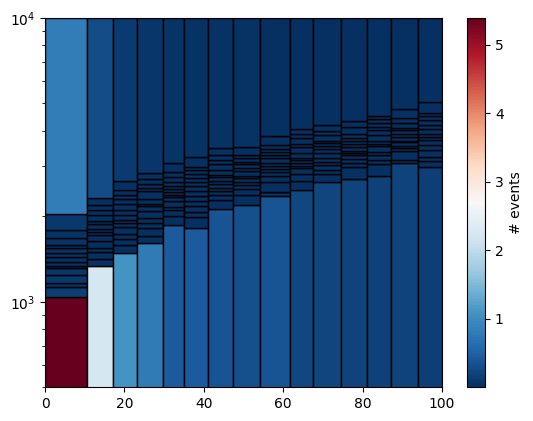

In [22]:
apt.utils.plot_irreg_histogram_2d(bins_cs1, bins_cs2, h, density=False)
plt.yscale("log")
plt.ylim(5e2, 1e4)
plt.show()